#### Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline





### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [34]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

In [13]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [22]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [35]:
# Identify missing or unknown data values and convert them to NaNs.öo

# extracting columns names
column_names = azdias.columns
column_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [6]:
missing_unknown = feat_info['missing_or_unknown']
missing_unknown

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [36]:
# convert missing values to nan
def convert_missing_to_nan(df):
    for i,item in zip(range(len(df)), df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',')
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            
            df[column_name] = df[column_name].replace(miss,np.nan)
            
    return df, missing_unknown

azdias,  missing_unknown = convert_missing_to_nan(azdias)

In [8]:
azdias.isnull().sum().head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [9]:
azdias.dropna(how='any').shape, azdias.dropna(how='all').shape

((143, 85), (891221, 85))

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [37]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
check_missing_column_values = azdias.isnull().sum()
check_missing_column_values


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [38]:
# selecting only columns with missing values
missing_column_values = check_missing_column_values[check_missing_column_values > 0]

missing_column_values.sort_values(inplace=True, ascending=False)
missing_column_values

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

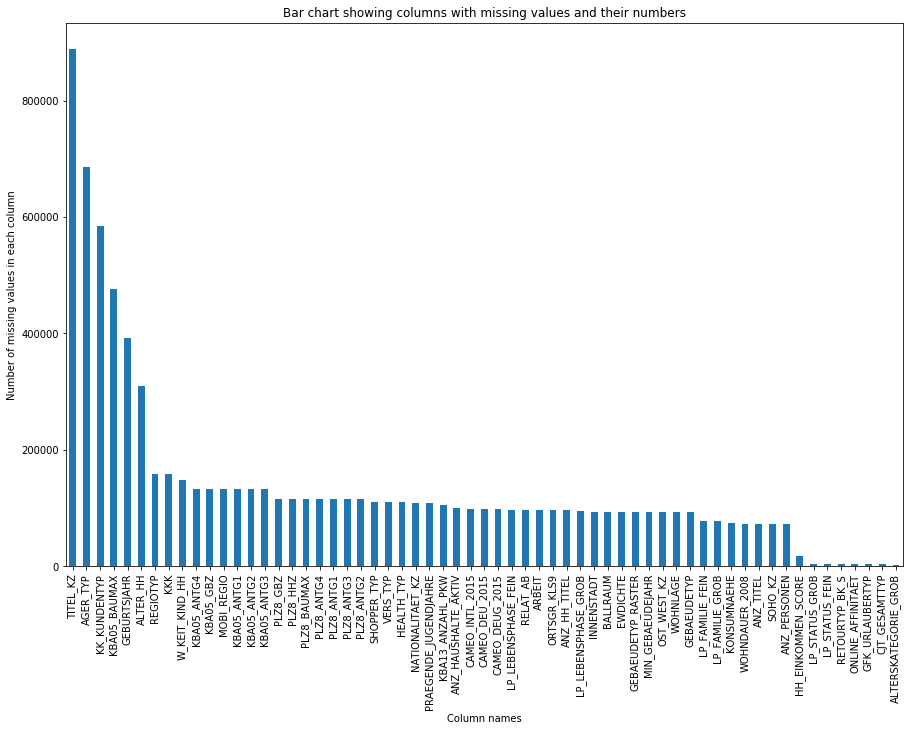

There are 61 columns with missing values.


In [7]:
# visualising bar chart of missing columns values
missing_column_values.plot.bar(figsize=(15,10))
plt.xlabel('Column names')
plt.ylabel('Number of missing values in each column')
plt.title('Bar chart showing columns with missing values and their numbers')
plt.show()
print("There are {} columns with missing values.".format(len(missing_column_values)))

In [39]:
# Investigate patterns in the amount of missing data in each column.
mcv_percent=missing_column_values.sort_values()/float(len(azdias)) * 100
mcv_percent

ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
CJT_GESAMTTYP             0.544646
ONLINE_AFFINITAET         0.544646
GFK_URLAUBERTYP           0.544646
RETOURTYP_BK_S            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
GEBAEUDETYP              10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

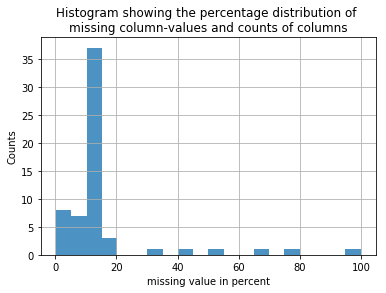

In [25]:
# visualising percentage distribution of missing column-values
plt.hist(mcv_percent, bins=20, alpha = 0.8);
plt.xlabel('missing value in percent')
plt.ylabel('Counts')
plt.title('Histogram showing the percentage distribution of \nmissing column-values and counts of columns')
plt.grid(True)
plt.show()

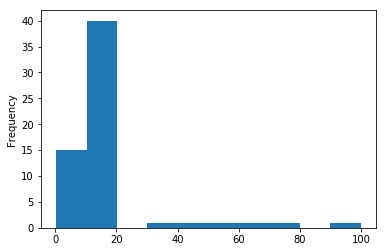

In [24]:
mcv_percent.plot.hist()

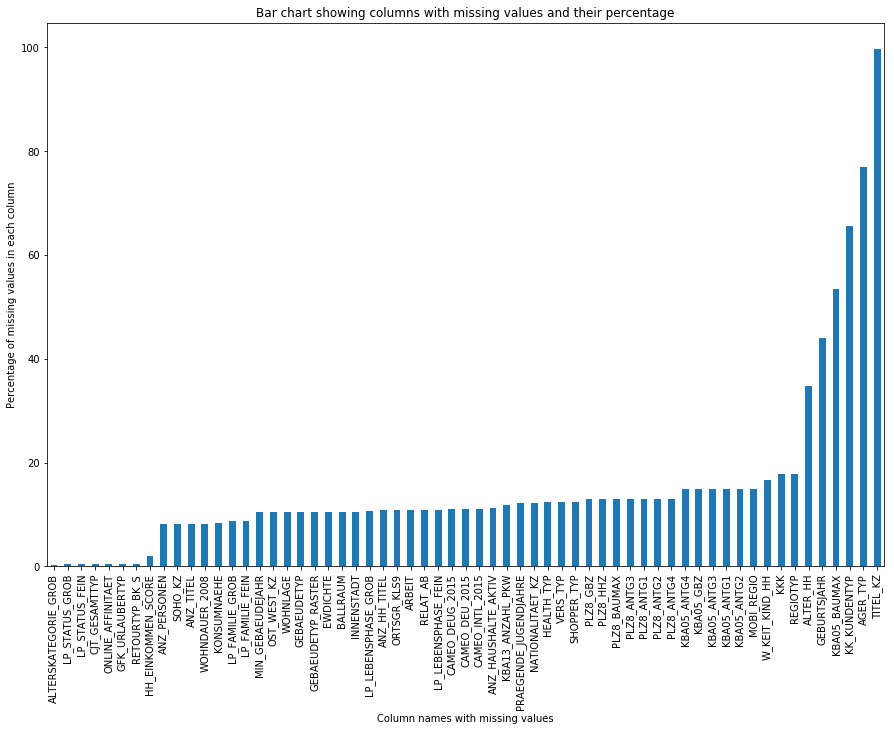

There are 61 columns with missing values.


In [8]:
# visualising percentage bar chart of missing columns values
mcv_percent.plot.bar(figsize=(15,10))
plt.xlabel('Column names with missing values')
plt.ylabel('Percentage of missing values in each column')
plt.title('Bar chart showing columns with missing values and their percentage')
plt.show()
print("There are {} columns with missing values.".format(len(mcv_percent)))

In [40]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Removing column with more than 30 percent missing data

# Finding names of colums with more than 30  percent missing values 
mcv_greater_30 =[]
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 30:
        mcv_greater_30.append(col)

mcv_greater_30

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [41]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Removing column with more than 30 percent missing data
azdias = azdias.drop(mcv_greater_30,axis=1)
azdias.head()

print(f'{len(mcv_greater_30)} columns greater than 30% in missing column values were dropped')
print(f'{azdias.shape[1]} columns are remaining')

azdias.columns

6 columns greater than 30% in missing column values were dropped
79 columns are remaining


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column
The column with the highest missing value is 'TITEL_KZ' with 99%
Most of the columns contain less than 20 percent missing value
Six of the columns; 'TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'  have greater than 30 percent missing data. 
Therefore, using a thresold of 30%, these six(outliers) columns were dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [42]:
# How much data is missing in each row of the dataset?
check_missing_row_values = azdias.isnull().sum(axis=1)
missing_row_values = check_missing_row_values[check_missing_row_values > 0]
missing_row_values.sort_values(inplace=True, ascending=False)
missing_row_values

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

In [43]:
# calculating the percent of missing values in a row
mrv_percent=missing_row_values.sort_values()/azdias.shape[1] * 100
mrv_percent

237075     1.265823
110252     1.265823
110249     1.265823
110232     1.265823
884377     1.265823
292273     1.265823
309312     1.265823
177403     1.265823
308874     1.265823
539502     1.265823
884695     1.265823
308889     1.265823
884661     1.265823
674335     1.265823
110352     1.265823
664958     1.265823
884622     1.265823
110346     1.265823
308975     1.265823
308988     1.265823
664952     1.265823
110302     1.265823
309043     1.265823
674239     1.265823
309051     1.265823
544336     1.265823
664919     1.265823
884646     1.265823
747312     1.265823
2775       1.265823
            ...    
526503    59.493671
839556    59.493671
839529    59.493671
453402    59.493671
527069    59.493671
453376    59.493671
839537    59.493671
183492    59.493671
527051    59.493671
288864    59.493671
183496    59.493671
221224    59.493671
183499    59.493671
318326    59.493671
453260    59.493671
221169    59.493671
27531     59.493671
527002    59.493671
318322    59.493671


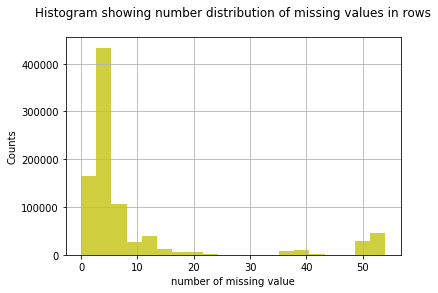

In [20]:
plt.hist(check_missing_row_values, bins=20, facecolor='y', alpha=0.75)
plt.xlabel('number of missing value')
plt.ylabel('Counts')
plt.title('Histogram showing number distribution of missing values in rows\n')
plt.grid(True)
plt.show()

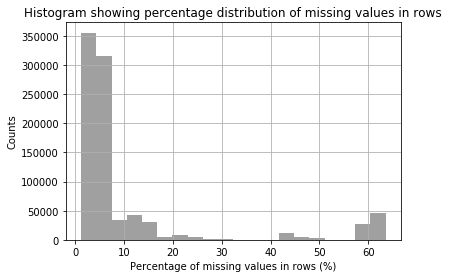

In [21]:
# visualising the histogram of percentage missing row values
plt.hist(mrv_percent, bins=20, facecolor='grey', alpha=0.75)
plt.xlabel('Percentage of missing values in rows (%)')
plt.ylabel('Counts')
plt.title('Histogram showing percentage distribution of missing values in rows')
plt.grid(True)
plt.show()

In [44]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# dividing the data into 2 subsets based on rows having at least 30% of missing values or greater
# i.e., low and high containing missing row values
low_containing_mrv = azdias[azdias.isnull().sum(axis=1) < 30].reset_index(drop=True)
high_containing_mrv = azdias[azdias.isnull().sum(axis=1) >= 30].reset_index(drop=True)

print(f'High missing row value is: {len(high_containing_mrv)/len(azdias)*100},low missing row value is: {len(low_containing_mrv)/len(azdias)*100}')

High missing row value is: 10.4530750509694,low missing row value is: 89.5469249490306


In [39]:
low_containing_mrv.index, high_containing_mrv.index

(RangeIndex(start=0, stop=797929, step=1),
 RangeIndex(start=0, stop=93292, step=1))

In [45]:
# choosing some columns to analyse with little or no missing columns values
column_to_analyse = ['SEMIO_DOM',  'SEMIO_RAT', 'SEMIO_TRADV', 'ANREDE_KZ', 'ZABEOTYP']

In [46]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_compare(column):
    
    '''
    input: column name
    
    output: None
    '''
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many missing rows')
    sns.countplot(azdias.loc[high_containing_mrv.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing rows')
    sns.countplot(azdias.loc[~azdias.index.isin(low_containing_mrv),column]);

    fig.suptitle(column)
    plt.show()

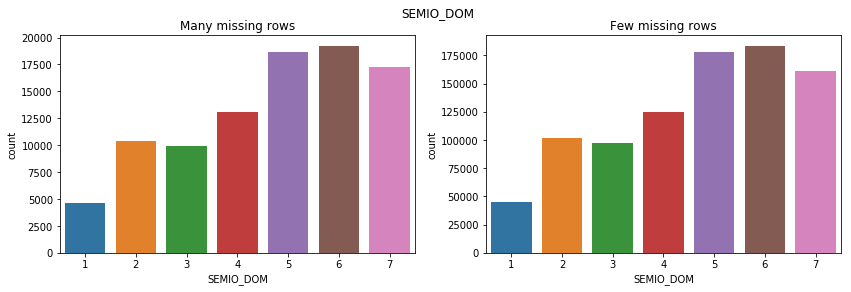

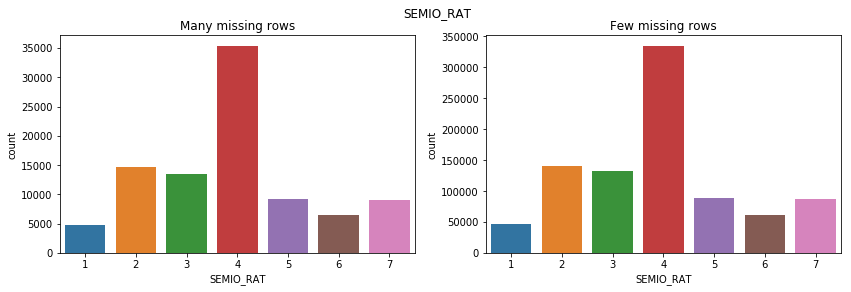

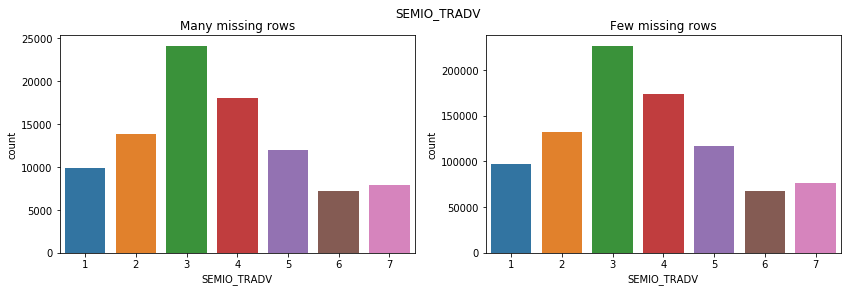

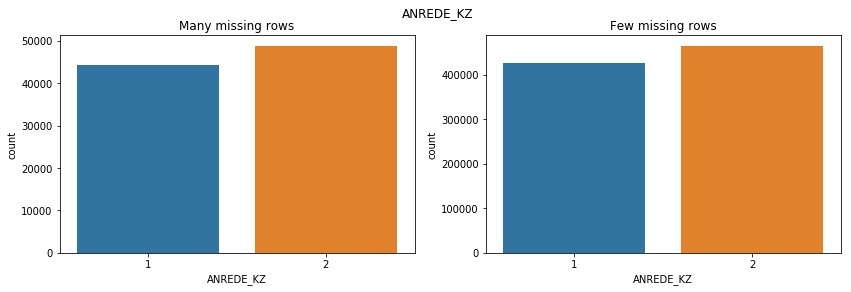

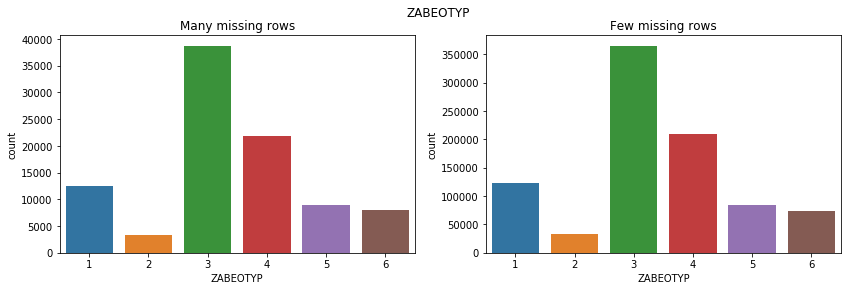

In [47]:
for column in column_to_analyse:
    plot_compare(column)

In [48]:
# selecting rows with high missing values
azdias_many_missing = azdias.iloc[high_containing_mrv.index]

print(f'Total rows in azdias dataset is {azdias.shape[0]}')

Total rows in azdias dataset is 891221


In [49]:
# dropping rrows with high missing values
azdias = azdias[~azdias.index.isin(high_containing_mrv.index)]
azdias.head()

print(f'{len(azdias_many_missing)} rows greater than 30% in missing row values were dropped')
print(f'{azdias.shape[0]} rows are remaining')

93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining


#### Discussion 1.1.3: Assess Missing Data in Each Row

8% of the total rows contains greater than 30% missing row values. Assumming a 30% thresold of missing row value. I plotted the distributions of rows (with low and high missing row values) on columns ('SEMIO_DOM',  'SEMIO_RAT', 'SEMIO_TRADV', 'ANREDE_KZ', 'ZABEOTYP') that have no missing values. After comparison, there were no considerable difference in their distributions. Therefore,   I dropped these rows

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [50]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [5]:
feat_info.type.dtypes

dtype('O')

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [51]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values

In [52]:
# selecting the categorical columns in azdias now
cat_columns = [cat_column for cat_column in cat_columns if cat_column in azdias.columns] 
cat_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [21]:
azdias[cat_columns].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [53]:
# Re-encode categorical variable(s) to be kept in the analysis.

col_binary = []
col_multi = []
for column in cat_columns:
    if azdias[column].nunique() > 2:
        col_multi.append(column)
    else:
        col_binary.append(column)

In [22]:
col_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [23]:
col_binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [19]:
azdias['OST_WEST_KZ'].unique()

array(['O', 'W', nan], dtype=object)

In [54]:
# dropping the multilevel categorical columns
azdias.drop(col_multi, axis=1, inplace=True)

In [51]:
azdias.shape[1]

66

In [55]:
# checking unique values in categorical binary column
for col in col_binary:
    print(azdias[col].value_counts())


2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64


In [56]:
# converting categorical binary variables with non-numeric values to numeric ( ANd those with float to integer?)
azdias.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)

In [57]:
# checking the column values and data types again
for col in col_binary:
    print(azdias[col].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
0    562845
1    152061
Name: OST_WEST_KZ, dtype: int64


#### Discussion 1.2.1: Re-Encode Categorical Features

I removed all the multilevel categorical features. Then, I encoded the non-numeric binary column 'OST_WEST_KZ' from [W,O] to [0,1]. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
93160,3.0
93161,7.0
93162,8.0
93163,14.0
93164,14.0


In [59]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def define_interval(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6
    
def define_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1

In [60]:
# adding new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movementrespectively
azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(define_interval)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(define_movement)

In [61]:
azdias['DECADES'].value_counts().sort_index()

1.0     25819
2.0     67891
3.0    104095
4.0    160580
5.0    135923
6.0    207280
Name: DECADES, dtype: int64

In [62]:
# Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Adding a feature based on wealth
def cameo_wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5

# Adding a feature based on lfe stage
def cameo_life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5
    
    

In [33]:
azdias['CAMEO_INTL_2015'].dtypes

dtype('O')

In [64]:
# converting to numerics
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [65]:
# adding new columns 'WEALTH'  and 'LIFE_STAGE' based on wealth and stage of life respectively
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(cameo_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(cameo_life_stage)
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
np.unique(azdias.dtypes.values)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [42]:
azdias.loc[:, azdias.dtypes == 'O']

,OST_WEST_KZ
93160,1
93161,1
93162,1
93163,1
93164,1
93165,1
93166,1
93167,0
93168,0
93169,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...    
    for i,item in zip(range(len(df)), df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',')
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            
            df[column_name] = df[column_name].replace(miss,np.nan)
            
   
    
    # removing selected columns i.e. rows having > 30% of missing values
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
    

    # removing selected rows i.e. rows having > 30% of missing values
    missing_row_values = df.isnull().sum(axis=1)
    missing_row_values.value_counts().sort_index(ascending=False,inplace=True)
    # dividing the rows into 2 subsets based on having missing value less than 30% or not<
    low_containing_mrv = df[df.isnull().sum(axis=1)<30].reset_index(drop=True)
    high_containing_mrv = df[df.isnull().sum(axis=1)>=30].reset_index(drop=True)
    # selecting rows with high missing values
    df_many_missing = df.iloc[high_containing_mrv.index]
    print(f'Total rows in dataset is {df.shape[0]}')
    
  

    # dropping rows with high missing values
    df = df[~df.index.isin(high_containing_mrv.index)]
    print(f'{len(df_many_missing)} rows greater than 30% in missing row values were dropped')
    print(f'{df.shape[0]} rows are remaining')
       
    
    # select, re-encode, and engineer column values.
    # dropping the multilevel categorical columns
    for column in df.columns:
        if column in col_multi:
            df.drop(column, axis=1, inplace=True)
            
   
    #df.drop(col_multi, axis=1, inplace=True)
    
    # encoding the 'OST_WEST_KZ' binary categorical column
    df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True) 
    
    # Engineering(converting) "PRAEGENDE_JUGENDJAHRE" and 'CAMEO_INTL_2015'into two new variables each     
    # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    # Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    
        
    # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    df['wealth'] = df['CAMEO_INTL_2015'].apply(cameo_wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(cameo_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    
    col_list = df.columns
       
    # impute NaN 
    imputer = Imputer(strategy='mean', axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=col_list)
    
    print('Done')

    # Return the cleaned dataframe.
    return df, df_many_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [30]:
# copying azdias
azdias_copy=azdias.copy()
col_list = azdias_copy.columns

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='mean', axis=0)
azdias_copy = imputer.fit_transform(azdias_copy)

In [32]:
# changing to dataframe again and checking for missing value
azdias_copy = pd.DataFrame(azdias_copy, columns= col_list)
azdias_copy.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
K

In [33]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_copy)
azdias_scaled = pd.DataFrame(azdias_scaled, columns= col_list)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.231412,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.052862,-0.832891,-1.703722,0.573007,0.536028,0.089457
1,0.240123,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.692964,0.427850,-0.367319,0.882833,1.245454,-0.054110,-0.973237,-1.985153,-1.636902,1.518387
2,0.240123,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.692964,-1.774003,-0.367319,-0.176995,-0.593198,-0.832891,-0.242752,0.573007,0.536028,1.518387
3,-0.751165,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,0.777350,0.427850,-0.367319,0.882833,-0.133535,-0.054110,1.218218,0.573007,1.260338,0.803922
4,-0.751165,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,1.218218,0.573007,0.536028,0.089457


### Discussion 2.1: Apply Feature Scaling

I imputed the missing values with the mean of the coulmns. Afterwards,  I used the the StandardScaler to scale the datarame

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
pca = PCA(whiten= True)
pca_features = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_features)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-0.798892,1.388954,-0.505207,-0.660795,0.683353,-1.281655,0.734902,-1.547718,0.120419,-0.236398,...,-0.131001,0.432933,0.068949,-1.756560,1.553867,0.502438,-0.862548,-0.164524,-0.425406,-0.886129
1,-0.689347,0.872358,0.982557,1.763106,0.148761,-1.687299,-0.555573,2.011777,0.336690,0.345617,...,0.291010,0.399651,0.206677,1.098490,0.039459,-0.254308,0.131675,-0.029364,1.185084,-0.633473
2,-1.182179,-0.179367,-1.063167,-0.141120,2.722845,-0.182616,0.361272,0.499897,2.184808,0.598054,...,2.036994,0.521842,1.389168,0.180356,1.573760,-2.697732,-1.790334,-0.052206,-2.074894,0.865548
3,1.382530,-1.115816,1.124085,-0.739182,-0.790433,-0.185841,-0.450581,-2.889249,0.832689,0.112001,...,1.535347,-1.222966,0.086689,-0.054613,0.481243,-1.622620,1.354743,-1.498705,-1.153423,-0.484798
4,-0.460898,-1.322260,-1.231314,-2.030032,0.606524,-1.663635,0.832371,-0.699465,-1.384082,1.323290,...,-0.022447,0.566872,0.617392,0.459702,-0.283790,-1.057828,-1.911539,-1.639273,-0.710052,-0.651603
5,-0.602200,-1.064805,-0.521439,0.073223,-1.328640,0.104080,0.271957,1.176807,0.941153,-0.145642,...,0.079940,-0.217253,-0.392917,-1.005545,1.828667,0.311858,1.540875,0.141058,0.131968,0.436953
6,-1.560219,0.459062,1.154895,-1.901391,0.639962,-2.049288,1.179713,-0.432668,-1.162798,0.411128,...,-0.441186,0.708249,0.491323,0.530038,-1.994457,0.026541,-0.661674,0.599226,0.437183,-1.024592
7,-1.257305,-1.993545,1.429824,-0.429085,1.737240,0.518068,0.227185,0.915203,-1.199898,0.081323,...,-0.403088,1.764534,0.825944,1.661448,1.007793,-0.819909,-2.723387,-1.321449,-1.211677,0.113088
8,-0.965496,0.320463,-0.639453,2.768253,0.713000,1.180443,-0.446218,-0.080760,1.084408,0.084501,...,2.314601,0.890237,-0.580213,-1.109933,-0.671319,0.939591,-1.533349,0.199409,-0.896654,-0.886270
9,-0.430268,0.664175,-0.649208,1.754522,0.093279,1.710694,-0.200994,-0.992678,0.900359,-0.773990,...,-0.106091,-0.249887,-1.079010,-0.635062,-0.476537,1.300506,-1.856148,1.001897,-1.803424,-0.065909


In [44]:
# selecting 4th row and 1st column of the dataframe
pd.DataFrame(pca_features)[0][4]

-0.46089788076894489

In [45]:
# explained variance for each component
pca.explained_variance_ratio_

array([  1.70005766e-01,   1.23067301e-01,   8.70677901e-02,
         5.45804823e-02,   4.02818275e-02,   3.27235615e-02,
         3.03152204e-02,   2.53889320e-02,   2.28427892e-02,
         2.13629113e-02,   2.08274493e-02,   1.96331736e-02,
         1.89681673e-02,   1.77372676e-02,   1.75175241e-02,
         1.57465961e-02,   1.54595438e-02,   1.47043903e-02,
         1.33880175e-02,   1.24166671e-02,   1.22362867e-02,
         1.14185580e-02,   1.12867064e-02,   1.08496483e-02,
         1.05972935e-02,   9.52457823e-03,   9.43919161e-03,
         8.35886430e-03,   7.50655709e-03,   7.17559538e-03,
         6.89223984e-03,   6.70688983e-03,   6.40587732e-03,
         6.24987145e-03,   6.07837898e-03,   5.83184080e-03,
         5.59461528e-03,   5.23122940e-03,   4.69816718e-03,
         4.47306249e-03,   4.35704902e-03,   4.05764073e-03,
         3.98684291e-03,   3.82329287e-03,   3.65908517e-03,
         3.63451904e-03,   3.47045019e-03,   3.36707085e-03,
         3.14173079e-03,

In [46]:
# cummulative explained variance
np.cumsum(pca.explained_variance_ratio_)

array([ 0.17000577,  0.29307307,  0.38014086,  0.43472134,  0.47500317,
        0.50772673,  0.53804195,  0.56343088,  0.58627367,  0.60763658,
        0.62846403,  0.6480972 ,  0.66706537,  0.68480264,  0.70232016,
        0.71806676,  0.7335263 ,  0.74823069,  0.76161871,  0.77403538,
        0.78627166,  0.79769022,  0.80897693,  0.81982658,  0.83042387,
        0.83994845,  0.84938764,  0.8577465 ,  0.86525306,  0.87242866,
        0.8793209 ,  0.88602779,  0.89243366,  0.89868354,  0.90476191,
        0.91059376,  0.91618837,  0.9214196 ,  0.92611777,  0.93059083,
        0.93494788,  0.93900552,  0.94299236,  0.94681566,  0.95047474,
        0.95410926,  0.95757971,  0.96094678,  0.96408851,  0.96705765,
        0.96999188,  0.97272702,  0.97530828,  0.9778251 ,  0.98024616,
        0.98260671,  0.98478037,  0.98690787,  0.98894163,  0.99081752,
        0.99262127,  0.99437419,  0.99595232,  0.99745836,  0.99865074,
        0.99981464,  0.99992504,  1.        ])

In [47]:
num_components = len(pca.explained_variance_ratio_)
num_components

68

In [48]:
pca_features.sum(axis=0)

array([  2.44284593e-11,   2.60911293e-11,   6.15756335e-11,
        -1.13686838e-12,  -1.13828946e-11,  -3.00204306e-11,
         1.13686838e-13,   1.43813850e-11,   1.91704430e-11,
        -1.56887836e-11,  -5.33759703e-11,   2.68371991e-11,
        -1.51985091e-11,   3.40349970e-11,  -2.02646788e-11,
         6.11777295e-12,  -1.25055521e-12,   2.02931005e-11,
         5.92947913e-11,  -1.57740487e-11,  -2.84217094e-13,
         7.98650035e-12,   1.86091142e-11,   7.36193329e-11,
        -4.08846290e-11,   2.09610107e-12,  -3.12638804e-13,
        -2.19912977e-11,  -2.82511792e-11,   2.72279976e-11,
        -8.34461389e-11,  -4.32827107e-11,  -3.12176951e-11,
         8.33608738e-11,  -1.43813850e-11,   1.48361323e-11,
        -2.26663133e-11,  -3.36157768e-11,  -8.58619842e-11,
        -2.99174019e-11,  -9.41113854e-12,   5.37525580e-11,
         4.46593873e-11,   3.01483283e-11,  -4.26041424e-11,
        -7.64579511e-11,  -5.04911668e-11,   6.54267751e-11,
        -5.70423708e-11,

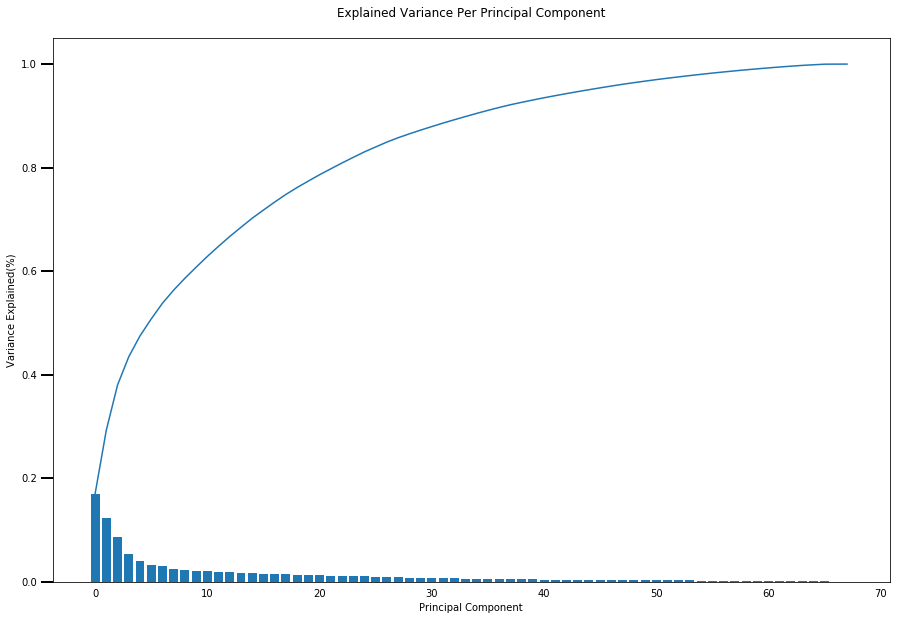

In [53]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    values = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot()
    cumvalues = np.cumsum(values)
    ax.bar(index, values)
    ax.plot(index, cumvalues)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained(%)")
    plt.title('Explained Variance Per Principal Component\n')


scree_plot(pca)


In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(25)
pca_features2 = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_features2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-2.716281,4.018036,-1.229305,-1.273048,1.130984,-1.912164,1.054632,-2.035575,0.149736,-0.286497,...,1.169996,0.035389,-0.089462,0.484307,0.495494,0.476711,1.688093,0.833434,0.698786,-0.352974
1,-2.343822,2.523600,2.390794,3.396702,0.246469,-2.516754,-0.797142,2.644153,0.416825,0.417988,...,1.125075,2.004681,-0.065144,-0.598907,0.378847,-0.602125,1.151331,0.565533,-0.524729,-0.047767
2,-4.019480,-0.518883,-2.586943,-0.271890,4.506499,-0.272630,0.517664,0.655168,2.723931,0.717235,...,0.881670,-0.283719,-0.104072,0.343510,-0.009086,-0.378668,-1.126481,-0.905160,0.169620,-1.325135
3,4.700684,-3.227889,2.735156,-1.424097,-1.308497,-0.277342,-0.647513,-3.797396,1.041119,0.132988,...,0.572646,0.614652,-0.072484,0.250788,0.583005,-1.050147,-0.402112,-0.794207,-0.947405,-1.787975
4,-1.567081,-3.825102,-2.996072,-3.910933,1.003977,-2.481497,1.194904,-0.919192,-1.725719,1.592187,...,1.007690,0.582099,-0.118847,1.137889,-1.237980,-0.447215,-0.454785,-0.159841,0.064016,-0.628742
5,-2.047516,-3.080322,-1.268784,0.141097,-2.198979,0.155153,0.390920,1.545397,1.172565,-0.173560,...,2.404392,0.846157,-0.018308,0.500065,0.904112,-0.482548,-0.122944,0.775181,1.098268,-1.448499
6,-5.304837,1.327998,2.810125,-3.663018,1.059312,-3.056950,1.694802,-0.567665,-1.453067,0.499687,...,0.574717,0.760968,-0.106351,0.695485,0.057055,0.290455,0.533425,0.219610,1.040324,0.842382
7,-4.274911,-5.767029,3.479084,-0.826584,2.875030,0.772942,0.326397,1.201387,-1.494637,0.099994,...,0.784422,0.985517,-0.131226,0.019527,1.424572,0.022828,0.339903,-0.099873,-0.258642,1.259314
8,-3.282744,0.927049,-1.555951,5.333317,1.180291,1.760959,-0.640597,-0.108809,1.352451,0.108598,...,-0.903234,0.024859,-0.156856,-0.113430,-0.252858,-0.535066,-0.050634,0.154072,-0.808188,0.549176
9,-1.462939,1.921357,-1.579672,3.380147,0.154485,2.552006,-0.288494,-1.303619,1.120995,-0.932415,...,-1.979753,0.768787,-0.082736,-0.811397,0.131337,-1.280381,-0.863998,0.072750,-1.737966,0.211885


### Discussion 2.2: Perform Dimensionality Reduction
From the scree plot above, it is observed that at about 25 components, more than 80% of the variance explained in the dataset is already accounted for. Thus, I have retained 25 components for the next step analysis.


(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_of_pcafeatures(pca, i):
    weight_map = {}
    for counter, feature in enumerate(azdias_scaled.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    weights_sorted = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return weights_sorted


In [37]:
weights_pc1 = weights_of_pcafeatures(pca, 1)
weights_pc1

[('ALTERSKATEGORIE_GROB', 0.27900119969269926),
 ('FINANZ_VORSORGER', 0.25879552270629125),
 ('SEMIO_ERL', 0.22834269027035067),
 ('SEMIO_LUST', 0.19019203144070501),
 ('RETOURTYP_BK_S', 0.17232727213349602),
 ('W_KEIT_KIND_HH', 0.1230290229472092),
 ('FINANZ_MINIMALIST', 0.11140400948356927),
 ('FINANZ_HAUSBAUER', 0.090193133283531138),
 ('WOHNDAUER_2008', 0.070304114921758976),
 ('EWDICHTE', 0.065793329410516771),
 ('ORTSGR_KLS9', 0.064654065921014636),
 ('PLZ8_ANTG3', 0.061682677090757532),
 ('SEMIO_KRIT', 0.059799620481178102),
 ('PLZ8_ANTG4', 0.058822126798102704),
 ('SEMIO_KAEM', 0.055430688523373892),
 ('PLZ8_BAUMAX', 0.054468773449576562),
 ('ANREDE_KZ', 0.05193233062508721),
 ('ARBEIT', 0.048295928208167117),
 ('RELAT_AB', 0.046472655569222927),
 ('KBA05_ANTG4', 0.046090241853355508),
 ('HH_EINKOMMEN_SCORE', 0.045022016743293813),
 ('WEALTH', 0.044143405902971715),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198842577763137),
 ('PLZ8_ANTG2', 0.042513039110360688),
 ('VERS_TYP', 0.0309845847

In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pc2 = weights_of_pcafeatures(pca, 2)
weights_pc2

[('SEMIO_VERT', 0.35408566897107335),
 ('SEMIO_SOZ', 0.29041065929954363),
 ('SEMIO_KULT', 0.28227262283568805),
 ('SEMIO_FAM', 0.23813906285483977),
 ('FINANZ_MINIMALIST', 0.1383804666292727),
 ('RETOURTYP_BK_S', 0.078550460832802052),
 ('SEMIO_MAT', 0.06867659163001659),
 ('FINANZ_VORSORGER', 0.063929691055756285),
 ('W_KEIT_KIND_HH', 0.063298721224193263),
 ('GREEN_AVANTGARDE', 0.062239652703834768),
 ('SEMIO_REL', 0.060412725962423183),
 ('ALTERSKATEGORIE_GROB', 0.040162130106678733),
 ('PLZ8_BAUMAX', 0.035447659542381396),
 ('PLZ8_ANTG4', 0.032267536649811732),
 ('ORTSGR_KLS9', 0.031813581697257863),
 ('PLZ8_ANTG3', 0.03073952543981219),
 ('EWDICHTE', 0.030058150405969077),
 ('ARBEIT', 0.024320362647451549),
 ('RELAT_AB', 0.021150575368878023),
 ('WOHNDAUER_2008', 0.020418178124297349),
 ('PLZ8_ANTG2', 0.019594902627083438),
 ('HH_EINKOMMEN_SCORE', 0.019266027517121434),
 ('SEMIO_LUST', 0.017424935090843661),
 ('WEALTH', 0.016790237860587497),
 ('KBA05_ANTG4', 0.015866697547990947

In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc3 = weights_of_pcafeatures(pca, 3)
weights_pc3

[('GREEN_AVANTGARDE', 0.34788358329406943),
 ('EWDICHTE', 0.24853594856144437),
 ('ORTSGR_KLS9', 0.24731214152918879),
 ('LP_LEBENSPHASE_FEIN', 0.22174056313469326),
 ('LP_LEBENSPHASE_GROB', 0.21726250195932068),
 ('ANZ_PERSONEN', 0.19531418829952107),
 ('ONLINE_AFFINITAET', 0.16383248449053306),
 ('RELAT_AB', 0.10751113263816943),
 ('SEMIO_DOM', 0.1045900310616921),
 ('PLZ8_ANTG3', 0.10157775853810495),
 ('PLZ8_HHZ', 0.097147983921770376),
 ('PLZ8_ANTG2', 0.095933719669647352),
 ('KBA05_ANTG1', 0.087217675719792942),
 ('PLZ8_ANTG4', 0.086957417520661079),
 ('ARBEIT', 0.078150128935401034),
 ('SEMIO_KAEM', 0.075832464519855494),
 ('PLZ8_BAUMAX', 0.073431599054318633),
 ('FINANZ_MINIMALIST', 0.071359310405331236),
 ('FINANZ_UNAUFFAELLIGER', 0.062356928965238846),
 ('MOBI_REGIO', 0.057770433945828932),
 ('LIFE_STAGE', 0.050854228855419126),
 ('KBA05_GBZ', 0.044165702227285206),
 ('ANZ_TITEL', 0.042885879866463888),
 ('WOHNDAUER_2008', 0.039721473620787595),
 ('SEMIO_RAT', 0.0359771786781

### Discussion 2.3: Interpret Principal Components

For the Principal Component 1,
The strongest positive feature weights in descending order are:
ALTERSKATEGORIE_GROB
FINANZ_VORSORGER
SEMIO_ERL
SEMIO_LUST
ETOURTYP_BK_S

While the strongest negative feature weights in ascending order are:
FINANZ_UNAUFFAELLIGER
SEMIO_PFLICHT
SEMIO_REL
FINANZ_SPARER
DECADES
This implies that that these 10 variables have the most sizable roles in explaining the variation due to the principal component 1. 
The feature ALTERSKATEGORIE_GROB has the greatest impact of all. 
Perfect contrast exist between the positive and negative feature weights as  they are negatively correlated.
Features showing the same positive or negative weights are positively correlated (increases with each other)
Finally,  PC scores derived from PC1 (linear function of this PC1 and the observed values for those variables) show that individuals with PC1 scores less than 0 will tend to have greater values of the negative feature weights, and lower values for the remaining positive feature weights, whereas individuals with PC1 scores greater than 0 will tend to have greater values of positive feature weights, and lower of the remaining negative feature weights.




For the Principal Component 2,
The strongest positive feature weightsin descending order are:
SEMIO_VERT
SEMIO_SOZ
SEMIO_KULT
SEMIO_FAM
FINANZ_MINIMALIST

While the strongest negative feature weights in ascending order are:
SEMIO_ERL
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
ANREDE_KZ
This implies that that these 10 variables have the  most sizable roles in explaining the variation due to the principal component 2. 
The feature ANREDE_KZ has the greatest impact of all. 
Perfect contrast exist between the postive and negative feature weights as  they are negatively correlated.
Features showing the same positive or negative weights are positively correlated (increases with each other)
Finally,  PC2 scores derived from PC2 show that individuals with PC scores less than 0 tend to have greater values of the negative feature weights, and lower values for the remaining positive feature weights, whereas individuals with PC scores greater than 0 tend to have greater values of positive feature weights, and lower of the remaining negative feature weights.


(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
# Over a number of different cluster counts...
# compute the average within-cluster distances.
centers = list(range(2, 30, 2))  
scores = []
for center in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(pca_features2)
    
    # compute the average within-cluster distances.

    
    
    # Obtain a score related to the model fitpd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
    score = np.abs(model.score(pca_features2))
    scores.append(score)  

In [69]:
scores

[44012533.524046429,
 38388235.436294071,
 35523908.598277733,
 33699778.624468461,
 32234997.786565784,
 31191354.50381723,
 30073870.196174566,
 29101047.292016599,
 28805968.09192542,
 28104384.849000707,
 27575761.973354697,
 27115772.656135686,
 26553416.73873321,
 26224270.987984147]

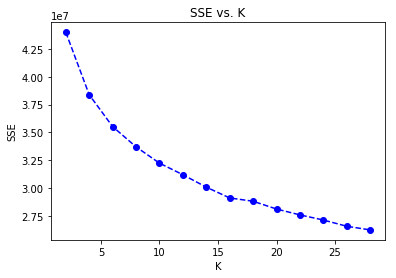

In [70]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [104]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
time_begin = time.time()
kmeans = KMeans(n_clusters=25)
model_gen = kmeans.fit(pca_features2)
predict_general = model_gen.predict(pca_features2)

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

Run time: 9.233 mins


In [105]:
predict_general

array([14,  2, 19, ..., 10, 12, 24], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population
AS seen above, the more pronounced elbow occured above 25 clusters. Therefore I  will separate the population into 25 clusters.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [107]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [80]:
customers.shape

(191652, 85)

In [108]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, customer_many_missing  = clean_data(customers)

Total rows in dataset is 191652
49927 rows greater than 30% in missing row values were dropped
141725 rows are remaining
Done


In [63]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,wealth,life_stage
0,1.0,2.0,2.0,5.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.000000,4.000000,4.000000,4.000000,7.000000,5.000000,2.884249,0.507327,1.00000,3.00000
1,3.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.554663,3.636646,3.624227,2.823007,5.117355,2.896732,2.884249,0.507327,2.59701,3.36958
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,2.000000,...,1.000000,4.000000,5.000000,4.000000,3.000000,5.000000,1.000000,1.000000,1.00000,5.00000
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.000000,...,1.000000,4.000000,4.000000,3.000000,6.000000,2.000000,2.000000,0.000000,1.00000,5.00000
4,4.0,2.0,2.0,1.0,5.0,1.0,1.0,5.0,0.0,1.000000,...,4.000000,3.000000,2.000000,3.000000,7.000000,5.000000,3.000000,1.000000,3.00000,1.00000


In [176]:
customers_clean.shape

(141725, 68)

In [83]:
list(set(azdias.columns) - set(customers_clean))

[]

In [84]:
len(customers_clean)

141725

In [109]:
customers_standardized = scaler.transform(customers_clean)
pca_customers = pca.transform(customers_standardized)
predict_customers = model_gen.predict(pca_customers)

In [110]:
pca_customers

array([[ 0.64074927, -1.06866848, -2.54480942, ...,  0.18054726,
         0.30193877,  1.40249499],
       [-1.14020676, -1.58125836, -2.29033529, ..., -0.20951468,
         0.19674878, -0.49876767],
       [-4.88074215,  1.65960321,  2.8735203 , ..., -1.52557729,
         0.69053999,  0.54434782],
       ..., 
       [-4.73934146,  3.70265516,  2.31590038, ..., -0.99721375,
        -0.2002285 ,  0.08532284],
       [-1.21414186,  2.69915739, -2.11648674, ..., -1.05829551,
        -0.6238104 , -0.01466312],
       [-4.84919633, -2.04544745,  2.75430645, ...,  0.3793029 ,
         0.37110367, -0.38306494]])

In [111]:
predict_customers

array([16, 16, 20, ...,  2,  5, 20], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [106]:
# no of predictions of persons in each cluster in the general data 
clusterno_predicted_general = pd.Series(predict_general).value_counts().sort_index()
clusterno_predicted_general

0      2814
1     43922
2     41386
3     37753
4     40007
5     41312
6     16926
7     39779
8     37964
9     33385
10    36631
11    22216
12    27704
13    27167
14    41118
15      711
16    71970
17     6135
18    25433
19    38955
20    36504
21    21513
22    39782
23    36110
24    30864
dtype: int64

In [113]:
# no of predictions of persons in each cluster in the customers data 
clusterno_predicted_customers = pd.Series(predict_customers).value_counts().sort_index()
clusterno_predicted_customers

0      2073
1       488
2     31361
3      2901
4       590
5      1759
6      1724
7     11147
8      3938
9       288
10      705
11     1107
12      454
13      877
14     5252
15      260
16    34293
17     1035
18     2565
19    10918
20     9307
21     1877
22     5964
23     3029
24     7813
dtype: int64

In [161]:
# creating dataframe for each cluster and the no of person belonging 
# to each cluster for both general and customers data
df_both = pd.concat([clusterno_predicted_general, clusterno_predicted_customers], axis=1).reset_index()
df_both.columns = ['clusters', 'pred_general', 'pred_customers']
df_both


,clusters,pred_general,pred_customers
0,0,2814,2073
1,1,43922,488
2,2,41386,31361
3,3,37753,2901
4,4,40007,590
5,5,41312,1759
6,6,16926,1724
7,7,39779,11147
8,8,37964,3938
9,9,33385,288


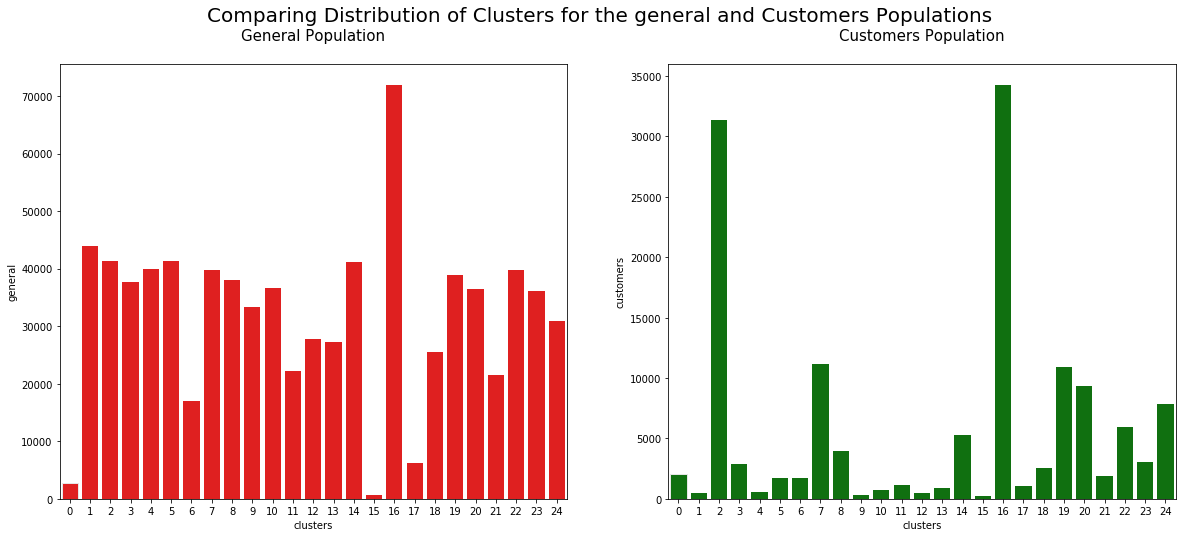

In [139]:
# Visualize dataframe as bar charts
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='clusters',y='general', data=df_both, color='r',edgecolor='.9')
plt.title("General Population\n", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='clusters',y='customers', data=df_both,color='g',edgecolor='.9')
plt.title("Customers Population\n", fontsize=15)
plt.suptitle("Comparing Distribution of Clusters for the general and Customers Populations\n", fontsize=20);

In [163]:
# calculating proportions of persons in both customer and general data
df_both['general_prop'] = (df_both['pred_general']/df_both['pred_general'].sum()*100).round(3)
df_both['customers_prop'] = (df_both['pred_customers']/df_both['pred_customers'].sum()*100).round(3)

# calculating the diferences between the two proportions
df_both['difference'] = df_both['general_prop'] - df_both['customers_prop']
df_both

,clusters,pred_general,pred_customers,general_prop,customers_prop,difference
0,0,2814,2073,0.353,1.463,-1.110
1,1,43922,488,5.504,0.344,5.160
2,2,41386,31361,5.186,22.128,-16.942
3,3,37753,2901,4.731,2.047,2.684
4,4,40007,590,5.013,0.416,4.597
5,5,41312,1759,5.177,1.241,3.936
6,6,16926,1724,2.121,1.216,0.905
7,7,39779,11147,4.984,7.865,-2.881
8,8,37964,3938,4.757,2.779,1.978
9,9,33385,288,4.183,0.203,3.980


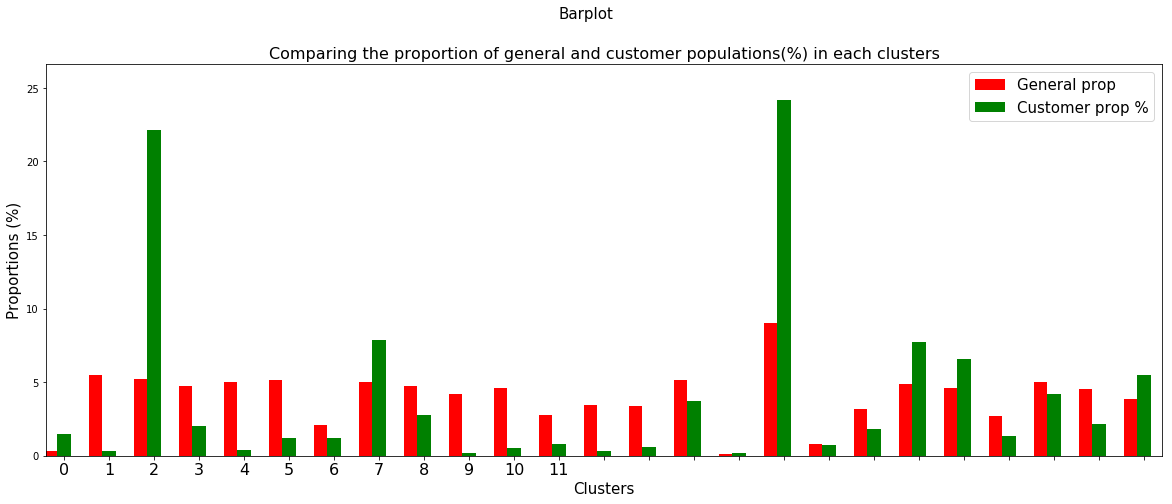

In [212]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,1,1)



ax = df_both['general_prop'].plot(x=df_both['clusters'], kind='bar',color='r',width=-0.3, align='edge',position=0)
ax = df_both['customers_prop'].plot(x=df_both['clusters'], kind='bar',color='g',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportions (%)', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('General prop', 'Customer prop %'),fontsize=15)
plt.title('Comparing the proportion of general and customer populations(%) in each clusters',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Barplot", fontsize=15)
plt.show()

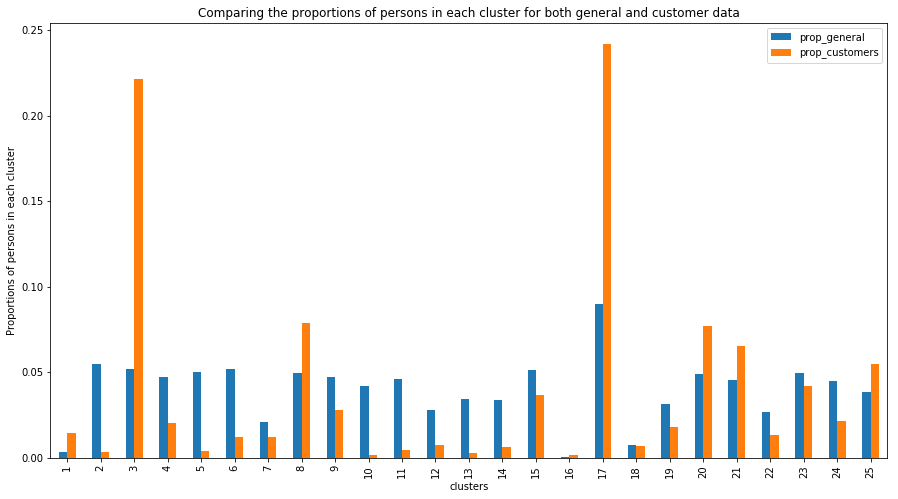

In [150]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_prop1 = []
customers_prop1 = []
x = [i+1 for i in range(25)]
for i in range(25):
    general_prop1.append((predict_general == i).sum()/len(predict_general))
    customers_prop1.append((predict_customers == i).sum()/len(predict_customers))


df_props = pd.DataFrame({'clusters' : x, 'prop_general' : general_prop1, 'prop_customers':customers_prop1})


df_props.plot(x='clusters', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(15,8))
plt.ylabel('Proportions of persons in each cluster')
plt.title('Comparing the proportions of persons in each cluster for both general and customer data')
plt.show()

In [204]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
initialdata_general1 = scaler.inverse_transform(pca.inverse_transform(pca_features2[np.where(predict_general==2)])).round(1)
initialdata_general1 = pd.DataFrame(initialdata_general1, columns=azdias.columns)

initialdata_general1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,3.2,1.1,5.4,1.1,4.3,1.7,1.2,2.3,1.0,3.1,...,2.2,3.7,3.1,4.3,8.0,3.0,2.9,-0.0,1.5,5.5
1,3.6,1.0,5.6,1.0,4.6,0.5,2.2,1.6,1.0,1.1,...,1.5,4.9,4.6,3.9,6.2,4.4,2.8,-0.0,2.1,3.2
2,3.5,1.0,5.2,0.9,5.0,0.5,2.5,2.6,0.9,0.9,...,1.7,3.1,3.2,1.9,5.3,1.7,2.3,0.0,1.0,4.7
3,3.9,0.8,5.3,1.0,5.3,1.4,2.3,2.5,-0.0,0.8,...,0.9,5.3,5.6,2.0,2.8,1.8,2.2,0.9,1.5,4.0
4,3.7,1.3,4.6,1.2,4.8,1.1,1.4,2.2,1.0,2.0,...,1.0,2.8,3.3,2.3,5.1,2.2,3.7,0.0,3.3,1.1


In [205]:
initialdata_customer1 = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(predict_customers==2)])).round(1)
initialdata_customer1=pd.DataFrame(initialdata_customer1, columns=azdias.columns)
initialdata_customer1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,3.5,1.0,5.5,0.5,5.3,0.2,1.8,2.4,1.0,0.9,...,1.4,4.1,4.3,2.6,5.8,2.6,2.2,-0.0,0.8,5.0
1,2.7,1.4,4.2,0.7,5.4,0.4,1.1,3.9,0.9,1.0,...,0.5,2.7,3.4,4.0,7.8,3.9,2.6,0.1,1.6,4.5
2,2.6,1.1,4.8,1.9,3.4,1.9,2.0,1.8,1.0,1.7,...,1.3,3.6,4.0,2.6,4.6,1.1,4.3,0.0,0.9,4.0
3,3.8,1.1,4.9,0.6,4.8,1.1,0.3,3.4,1.0,1.8,...,2.0,3.3,3.0,4.4,7.5,3.0,2.5,-0.0,2.0,5.0
4,3.6,1.1,4.4,1.0,4.9,0.3,1.6,3.3,1.0,1.0,...,0.0,2.9,4.0,3.8,5.9,4.1,2.7,0.0,2.4,2.9


In [189]:
# defining functions to scale and do pca
def get_sorted_weights(x):
      
    x = scaler.transform(x)
    x = pca.transform(x)
    
    return x

In [199]:
get_sorted_weights(initialdata_general1)

# getting wiehhts of pca
weights_of_pcafeatures(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.27900119225809472),
 ('FINANZ_VORSORGER', 0.25879548859932411),
 ('SEMIO_ERL', 0.22834268006207051),
 ('SEMIO_LUST', 0.19019202222293752),
 ('RETOURTYP_BK_S', 0.17232726993011707),
 ('W_KEIT_KIND_HH', 0.12302902372417499),
 ('FINANZ_MINIMALIST', 0.11140402909223381),
 ('FINANZ_HAUSBAUER', 0.090193116339359503),
 ('WOHNDAUER_2008', 0.070304076873151877),
 ('EWDICHTE', 0.065793335782597009),
 ('ORTSGR_KLS9', 0.064654085012442422),
 ('PLZ8_ANTG3', 0.061682673677753375),
 ('SEMIO_KRIT', 0.059799623870467597),
 ('PLZ8_ANTG4', 0.05882209862706865),
 ('SEMIO_KAEM', 0.055430711212259016),
 ('PLZ8_BAUMAX', 0.054468771108765801),
 ('ANREDE_KZ', 0.051932333216089449),
 ('ARBEIT', 0.04829594440935938),
 ('RELAT_AB', 0.046472630867815438),
 ('KBA05_ANTG4', 0.046090236526503972),
 ('HH_EINKOMMEN_SCORE', 0.045021972373899745),
 ('WEALTH', 0.044143377983989422),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198916660392016),
 ('PLZ8_ANTG2', 0.042513084158237825),
 ('VERS_TYP', 0.0309845822

In [198]:
get_sorted_weights(initialdata_customer1)

# getting wiehhts of pca
weights_of_pcafeatures(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.27900119225809472),
 ('FINANZ_VORSORGER', 0.25879548859932411),
 ('SEMIO_ERL', 0.22834268006207051),
 ('SEMIO_LUST', 0.19019202222293752),
 ('RETOURTYP_BK_S', 0.17232726993011707),
 ('W_KEIT_KIND_HH', 0.12302902372417499),
 ('FINANZ_MINIMALIST', 0.11140402909223381),
 ('FINANZ_HAUSBAUER', 0.090193116339359503),
 ('WOHNDAUER_2008', 0.070304076873151877),
 ('EWDICHTE', 0.065793335782597009),
 ('ORTSGR_KLS9', 0.064654085012442422),
 ('PLZ8_ANTG3', 0.061682673677753375),
 ('SEMIO_KRIT', 0.059799623870467597),
 ('PLZ8_ANTG4', 0.05882209862706865),
 ('SEMIO_KAEM', 0.055430711212259016),
 ('PLZ8_BAUMAX', 0.054468771108765801),
 ('ANREDE_KZ', 0.051932333216089449),
 ('ARBEIT', 0.04829594440935938),
 ('RELAT_AB', 0.046472630867815438),
 ('KBA05_ANTG4', 0.046090236526503972),
 ('HH_EINKOMMEN_SCORE', 0.045021972373899745),
 ('WEALTH', 0.044143377983989422),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198916660392016),
 ('PLZ8_ANTG2', 0.042513084158237825),
 ('VERS_TYP', 0.0309845822

In [209]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
initialdata_general2 = scaler.inverse_transform(pca.inverse_transform(pca_features2[np.where(predict_general==1)])).round(1)
initialdata_general2 = pd.DataFrame(initialdata_general2, columns=azdias.columns)
initialdata_general2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.2,1.9,2.1,2.0,4.9,2.2,1.9,5.3,-0.1,1.2,...,0.8,2.6,3.3,3.7,6.9,3.5,3.2,1.1,3.6,2.6
1,1.5,2.1,1.5,4.7,1.6,4.9,4.2,3.2,-0.0,2.1,...,0.5,2.8,3.8,4.1,5.8,4.1,5.8,1.0,4.1,1.0
2,2.1,1.9,3.7,2.5,3.3,3.0,3.1,1.9,0.1,2.3,...,2.0,3.6,3.4,3.1,5.3,3.1,4.2,0.9,2.9,2.8
3,1.1,2.1,1.1,4.3,2.0,4.8,3.4,5.3,-0.0,2.9,...,2.6,3.3,2.8,4.9,5.7,4.8,5.6,1.0,4.0,3.1
4,1.7,2.1,1.4,4.3,1.7,4.9,3.4,4.4,-0.0,2.0,...,3.2,3.2,2.4,4.3,4.6,4.2,5.4,1.0,5.2,1.5


In [211]:
initialdata_customer2 = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(predict_customers==1)])).round(1)
initialdata_customer2 = pd.DataFrame(initialdata_customer2, columns=azdias.columns)
initialdata_customer2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.4,2.1,2.6,1.4,5.4,2.1,1.4,5.4,1.0,1.2,...,1.4,4.8,4.5,3.6,5.1,3.5,2.8,0.1,3.9,2.7
1,1.8,2.0,4.3,0.8,5.2,1.5,1.1,2.9,0.0,2.1,...,1.4,4.0,4.0,3.7,6.2,4.0,2.5,1.0,4.0,1.1
2,1.9,1.9,1.9,3.0,3.1,2.8,2.6,3.6,-0.0,2.8,...,1.8,4.7,4.4,1.7,2.6,1.8,5.0,1.0,3.1,3.4
3,1.6,2.1,3.0,0.9,5.5,1.4,1.0,4.8,-0.0,1.9,...,2.3,3.9,3.2,4.2,7.3,5.0,2.4,1.0,4.2,3.5
4,1.7,2.2,2.4,2.5,3.1,3.6,1.4,4.3,0.0,2.2,...,1.5,5.0,4.6,4.4,6.4,2.9,4.2,1.0,3.8,3.1


In [200]:
get_sorted_weights(initialdata_general2)

# getting wiehhts of pca
weights_of_pcafeatures(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.27900119225809472),
 ('FINANZ_VORSORGER', 0.25879548859932411),
 ('SEMIO_ERL', 0.22834268006207051),
 ('SEMIO_LUST', 0.19019202222293752),
 ('RETOURTYP_BK_S', 0.17232726993011707),
 ('W_KEIT_KIND_HH', 0.12302902372417499),
 ('FINANZ_MINIMALIST', 0.11140402909223381),
 ('FINANZ_HAUSBAUER', 0.090193116339359503),
 ('WOHNDAUER_2008', 0.070304076873151877),
 ('EWDICHTE', 0.065793335782597009),
 ('ORTSGR_KLS9', 0.064654085012442422),
 ('PLZ8_ANTG3', 0.061682673677753375),
 ('SEMIO_KRIT', 0.059799623870467597),
 ('PLZ8_ANTG4', 0.05882209862706865),
 ('SEMIO_KAEM', 0.055430711212259016),
 ('PLZ8_BAUMAX', 0.054468771108765801),
 ('ANREDE_KZ', 0.051932333216089449),
 ('ARBEIT', 0.04829594440935938),
 ('RELAT_AB', 0.046472630867815438),
 ('KBA05_ANTG4', 0.046090236526503972),
 ('HH_EINKOMMEN_SCORE', 0.045021972373899745),
 ('WEALTH', 0.044143377983989422),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198916660392016),
 ('PLZ8_ANTG2', 0.042513084158237825),
 ('VERS_TYP', 0.0309845822

In [208]:
get_sorted_weights(initialdata_customer2)

# getting weights of pca
weights_of_pcafeatures(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.27900119225809472),
 ('FINANZ_VORSORGER', 0.25879548859932411),
 ('SEMIO_ERL', 0.22834268006207051),
 ('SEMIO_LUST', 0.19019202222293752),
 ('RETOURTYP_BK_S', 0.17232726993011707),
 ('W_KEIT_KIND_HH', 0.12302902372417499),
 ('FINANZ_MINIMALIST', 0.11140402909223381),
 ('FINANZ_HAUSBAUER', 0.090193116339359503),
 ('WOHNDAUER_2008', 0.070304076873151877),
 ('EWDICHTE', 0.065793335782597009),
 ('ORTSGR_KLS9', 0.064654085012442422),
 ('PLZ8_ANTG3', 0.061682673677753375),
 ('SEMIO_KRIT', 0.059799623870467597),
 ('PLZ8_ANTG4', 0.05882209862706865),
 ('SEMIO_KAEM', 0.055430711212259016),
 ('PLZ8_BAUMAX', 0.054468771108765801),
 ('ANREDE_KZ', 0.051932333216089449),
 ('ARBEIT', 0.04829594440935938),
 ('RELAT_AB', 0.046472630867815438),
 ('KBA05_ANTG4', 0.046090236526503972),
 ('HH_EINKOMMEN_SCORE', 0.045021972373899745),
 ('WEALTH', 0.044143377983989422),
 ('ANZ_HAUSHALTE_AKTIV', 0.043198916660392016),
 ('PLZ8_ANTG2', 0.042513084158237825),
 ('VERS_TYP', 0.0309845822

### Discussion 3.3: Compare Customer Data to Demographics Data

A good relatioship exist between the general and customers population data. From the above plots, the customers clusters are not universal (i.e., the customers are not uniformly distributed in the general population) with the population clusters so customers resides in certain clusters. The mail oreder company should target the clusters 2 and 16 where the customers data are over represented and neglect clusters 1,4, 10 where the customers clusters are under represented. Also, fromthe components of weight above, the over represented customer clusters shows that it belongs to category of older(45-60) and average income earners male.  

On the other hand, the customers clusters that are underrepresented belong to the category of younger and average earners females.




(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.